<a href="https://colab.research.google.com/github/siccohesselmans/colabpub/blob/master/horse_and_humans_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-gpu

# If appropriate, make sure you have run pip install --upgrade tensorflow_datasets 

Let's start loading the data and split 80% for test, 10% for validation, and 10% for test


In [ ]:
import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'horses_or_humans', split=list(splits),
    with_info=True, as_supervised=True)



In [ ]:
print(raw_train)
print(raw_validation)
print(raw_test)


<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
get_label_name = metadata.features['label'].int2str

def show_images(dataset): 
  for image, label in dataset.take(10):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

Let's inspect some images with an appropriate function


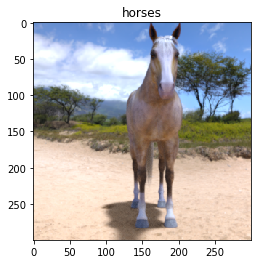

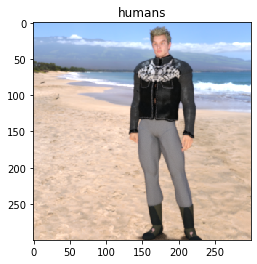

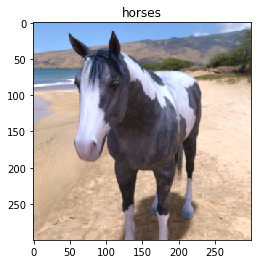

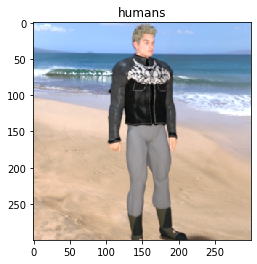

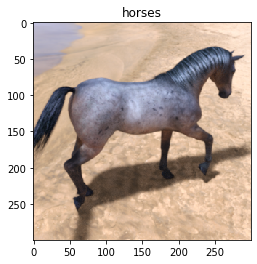

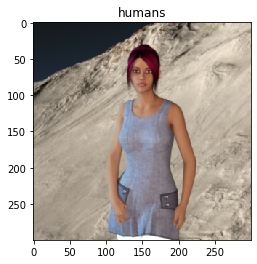

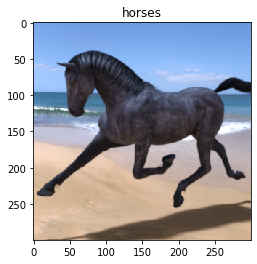

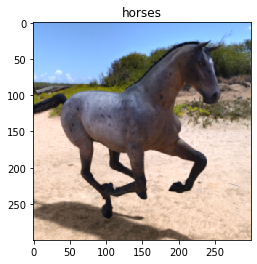

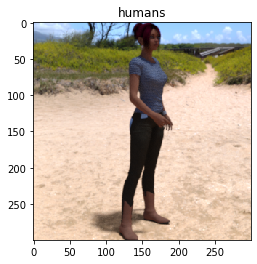

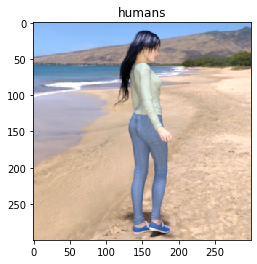

In [ ]:
show_images(raw_train)

resize the image to (160x160) with input channels to a range of [-1,1]

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

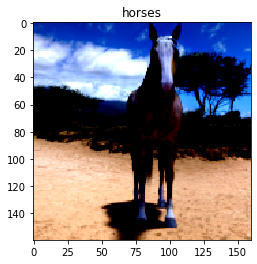

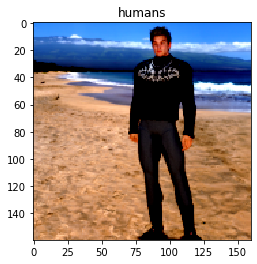

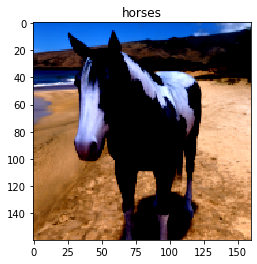

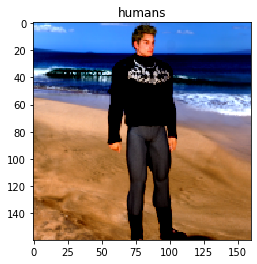

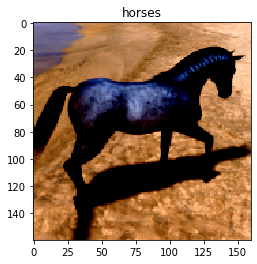

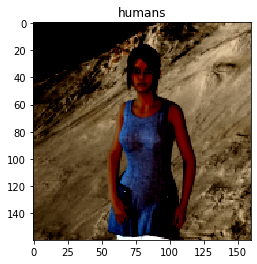

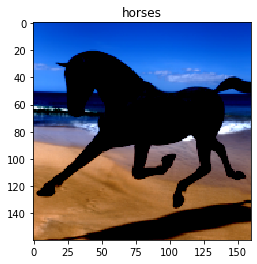

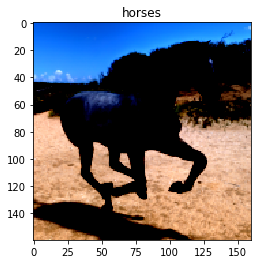

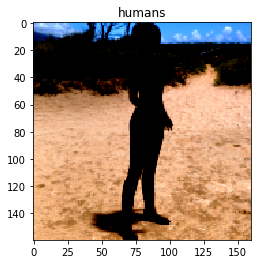

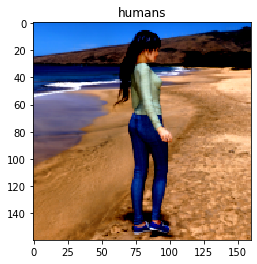

In [ ]:
show_images(train)

Then, we shuffle and batch the training set and batch the validation and test sets

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
print (train_batches)
print (validation_batches)
print (test_batches)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>


We can now use MobileNet with input (160, 160, 3) where 3 is the number of color channels.
The top layers are omitted (include_top=False) since we are going to use our own top layer.
All the layers are frozen because we use use pretrained weights.



In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass

Let's inspect a batch and see if the shapes are correct (32, 160, 160, 3) - they are!


In [ ]:
print (image_batch.shape)

(32, 160, 160, 3)


MobileNetV2 transforms each 160x160x3 image into a 5x5x1280 block of features.
For instance let's see the transformation applied to the batch

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Now, we can use GlobalAveragePooling2D() to average over the spatial 5x5 spatial locations and obtain a size of (32, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


The last layer is a Dense with logit if the prediction is positive the class is 1, if the prediction is negative the class is 0


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


Our model is ready to be composed by combined the base_model (MobileNet2 pre-trained), a global_average_layer to get the correct shape output given as input to the final prediction_layer


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

Now let's compile the model with an RMSProp() optimizer


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

If we display the composed model, we notice that there are more than two millions frozen parameters, and more than one thousands trainable parameters


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Let's compute the number of training, validation, and testing example

In [ ]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
print (num_train, num_val, num_test)

821.6 102.7 102.7


and compute the initial accuracy given by the pre-trained MobileNetv2


In [ ]:
initial_epochs = 20
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 4

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

4/4 [==============================] - 1s 298ms/step - loss: 4.3588 - accuracy: 0.6200


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.36
initial accuracy: 0.62


We can now fine-tune the composed network with by training for a few iteration and optimizing the non-frozen layers


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
26/26 [==============================] - 7s 269ms/step - loss: 3.0179 - accuracy: 0.6336 - val_loss: 3.8782 - val_accuracy: 0.6700
Epoch 2/20
26/26 [==============================] - 5s 193ms/step - loss: 2.2620 - accuracy: 0.6977 - val_loss: 3.5015 - val_accuracy: 0.7100
Epoch 3/20
26/26 [==============================] - 5s 198ms/step - loss: 1.8975 - accuracy: 0.7328 - val_loss: 3.3124 - val_accuracy: 0.7400
Epoch 4/20
26/26 [==============================] - 5s 196ms/step - loss: 1.6514 - accuracy: 0.7678 - val_loss: 3.0889 - val_accuracy: 0.7600
Epoch 5/20
26/26 [==============================] - 5s 198ms/step - loss: 1.4656 - accuracy: 0.7823 - val_loss: 3.2642 - val_accuracy: 0.7500
Epoch 6/20
26/26 [==============================] - 5s 197ms/step - loss: 1.1023 - accuracy: 0.8174 - val_loss: 3.0786 - val_accuracy: 0.7900
Epoch 7/20
26/26 [==============================] - 5s 196ms/step - loss: 1.1356 - accuracy: 0.8198 - val_loss: 2.8949 - val_accuracy: 0.8500
Epoch 